<div>
<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px" width=100>
</div>

# Project 3: Web APIs & NLP

## Progress so far

In [Part 1](./01_Data_Collection.ipynb) of the project, using the [Pushshift's](https://github.com/pushshift/api) API, posts are collected from the two subreddits of [nosleep](https://www.reddit.com/r/nosleep/) and [paranormal](https://www.reddit.com/r/paranormal/), and then compiled into CSVs. 

In [Part 2](./02_EDA_and_Data_Cleaning.ipynb) of the project, we have also completed the basic EDA and cleaning the two datasets to prep for analysis. The two datasets are then compiled into a single dataframe of only two columns: `subreddit` and `text`. 

After that, preprocessing of the dataframe is done through the use of tokenization, lemmatization, stemming and stop word removals. The final dataframe is then saved for this next part of the project.

## Part 3: Modelling and Analysis

### Imports (All imported libraries are added here)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay 
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from wordcloud import WordCloud

### Importing the Dataset

In [2]:
# Importing the preprocessed dataset
df = pd.read_csv('../datasets/data_model.csv')

In [3]:
# Checking the first 5 rows 
df.head()

,subreddit,text,text_stop,text_lem,text_stem
0,1,I created a new plant. It's gonna hurt a lot o...,created new plant gonna hurt lot people create...,created new plant gonna hurt lot people create...,creat new plant gonna hurt lot peopl creat new...
1,1,The people I kill won't stay dead. I'm not wri...,people kill stay dead writing sort confession ...,people kill stay dead writing sort confession ...,peopl kill stay dead write sort confess event ...
2,1,Don't got to the Magic Show at the Gypsy Carni...,got magic show gypsy carnival final part 1 l p...,got magic show gypsy carnival final part 1 l p...,got magic show gypsi carniv final part 1 l par...
3,1,"""Intent: The Truth"" - Randonauting is not that...",intent truth randonauting fun hell ella exclai...,intent truth randonauting fun hell ella exclai...,intent truth randonaut fun hell ella exclaim w...
4,1,Accused in the Woods I have had the privilege ...,accused woods privilege living america country...,accused wood privilege living america country ...,accus wood privileg live america countri one f...


In [4]:
# Checking the shape of dataframe
df.shape

(1450, 5)

### Top Word Features

At this point in time, let's do a quick check on the top occurring words for the two datasets. We will be using `CountVectorizer` to do this.

In [5]:
# Instantiate a CountVectorizer with stop words
cvec_nosleep = CountVectorizer(stop_words='english')

# Fit the vectorizer on our corpus.
cvec_nosleep.fit(df[df['subreddit'] == 1]['text_stem'])

# Transform 
Z_nosleep = cvec_nosleep.transform(df[df['subreddit'] == 1]['text_stem'])

(625, 17355)

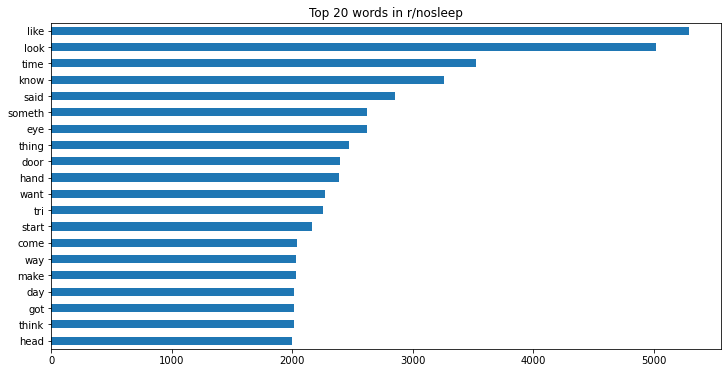

In [6]:
# Convert Z_nosleep into a DataFrame.
Z_nosleep_df = pd.DataFrame(Z_nosleep.todense(), 
                            columns=cvec_nosleep.get_feature_names_out())

# display shape of Z_nosleep_df
display(Z_nosleep_df.shape)

# plot top occuring words
plt.figure(figsize=(12, 6));
plt.title('Top 20 words in r/nosleep');
Z_nosleep_df.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh');

In [7]:
# Instantiate a CountVectorizer with stop words
cvec_paranormal = CountVectorizer(stop_words='english')

# Fit the vectorizer on our corpus.
cvec_paranormal.fit(df[df['subreddit'] == 0]['text_stem'])

# Transform 
Z_paranormal = cvec_paranormal.transform(df[df['subreddit'] == 0]['text_stem'])

(825, 6913)

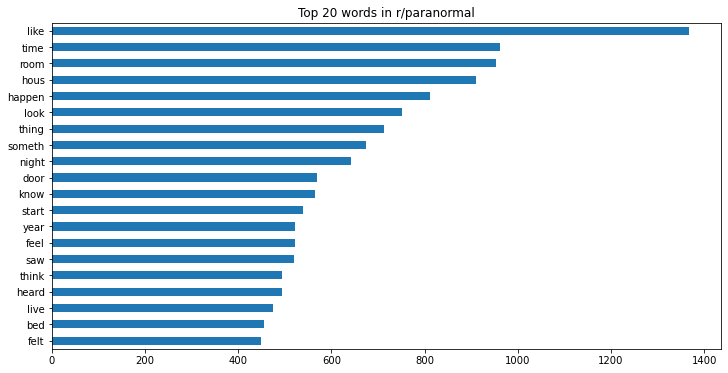

In [8]:
# Convert Z_paranormal into a DataFrame.
Z_paranormal_df = pd.DataFrame(Z_paranormal.todense(), 
                              columns=cvec_paranormal.get_feature_names_out())

# display shape of Z_nosleep_df
display(Z_paranormal_df.shape)

# plot top occuring words
plt.figure(figsize=(12, 6));
plt.title('Top 20 words in r/paranormal');
Z_paranormal_df.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh');

From the two plots of the top 20 word features of each subreddit, it is surprising to see that there are no clear defining words that suggest which subreddit the word comes from. In fact, it is interesting to note that there are many common word features between the two. Also, the first subreddit having more word features and higher count in said word features despite having less posts compared to the second subreddit means it is a lot more text-heavy. 

For the purpose of the modelling, since these would not be useful in our analysis, we would be removing the following common words:  
['like', 'look', 'time', 'know', 'someth', 'thing', 'door', 'start', 'think']

In [9]:
print(list(Z_nosleep_df.sum().sort_values(ascending = True).tail(20).index))

['head', 'think', 'got', 'day', 'make', 'way', 'come', 'start', 'tri', 'want', 'hand', 'door', 'thing', 'eye', 'someth', 'said', 'know', 'time', 'look', 'like']


In [10]:
# creating lists of the top 20 features of both subreddits
nosleep_features_list = list(Z_nosleep_df.sum().sort_values(ascending = False).head(20).index)
paranormal_features_list = list(Z_paranormal_df.sum().sort_values(ascending = False).head(20).index)

# Identifying the common features
common_features_list = [feat for feat in nosleep_features_list if feat in paranormal_features_list]
common_features_list

['like', 'look', 'time', 'know', 'someth', 'thing', 'door', 'start', 'think']

In [11]:
# creating a new list of stop words
stopwordslist = list(CountVectorizer(stop_words='english').get_stop_words()) + common_features_list

In [12]:
# Instantiate the WordCloud with the stopwords
wordcloud = WordCloud(background_color = None, mode = 'RGBA', stopwords = stopwordslist)

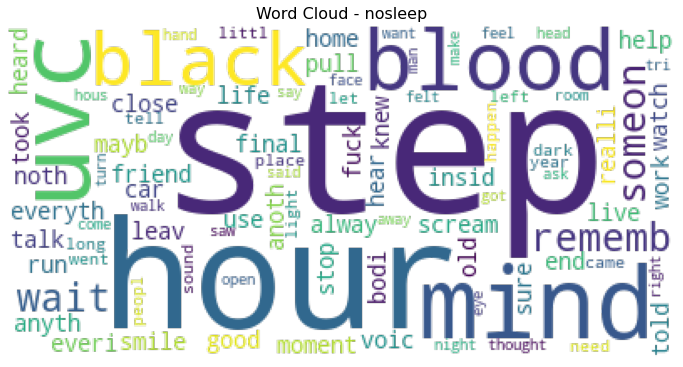

In [13]:
# Word Cloud of nosleep
nosleep_top_words = Z_nosleep_df[(pd.DataFrame(Z_nosleep_df.sum().sort_values(ascending = True).tail(100))).index]

wordcloud_nosleep = wordcloud.generate(' '.join(nosleep_top_words))

plt.figure(figsize = (12,10))
plt.imshow(wordcloud_nosleep)
plt.title('Word Cloud - nosleep', fontsize=16)
plt.axis("off");

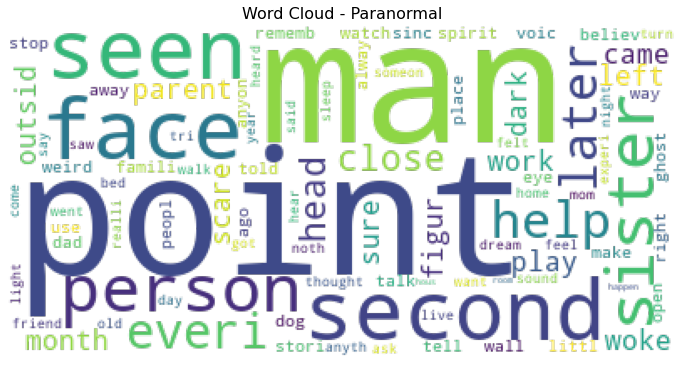

In [14]:
# Word Cloud of paranormal
paranormal_top_words = Z_paranormal_df[(pd.DataFrame(Z_paranormal_df.sum().sort_values(ascending = True).tail(100))).index]

wordcloud_paranormal = wordcloud.generate(' '.join(paranormal_top_words))

plt.figure(figsize = (12,10))
plt.imshow(wordcloud_paranormal)
plt.title('Word Cloud - Paranormal', fontsize=16)
plt.axis("off");

### Modelling

For the modelling process, since we are attempting to train our model based solely on the text content of the subreddit post, the only feature (ie X variable) will be one of the above `text` columns. The four `text` columns are namely the `text` columns that have undergone text preprocessing of: None, Lemmentization, Stemming, or Lemmentization and Stemming.

In the modelling process, we will be using one of the two transformers `CountVectorizer` or `TFIDVectorizer`, and one of the following estimators: `MultinomialNB`, `LogisticRegression`, `KNeighborsClassifier`, `RandomForestClassifier`.

#### Set up the data for modelling

For now, the target variable is the `subreddit` column, and the feature column chosen will be the `text_stemlem` column. The value of 1 for `subreddit` is for `nosleep` and the value of 0 is for `paranormal`.

In [15]:
# determining the X and y variables
X = df['text_stem']
y = df['subreddit']

# shape of X and y variables
display(X.shape)
display(y.shape)

(1450,)

(1450,)

In [16]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42)

In [17]:
# baseline accuracy
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.568537
1    0.431463
Name: subreddit, dtype: float64
0    0.570248
1    0.429752
Name: subreddit, dtype: float64


|Model|Transformer|Train Score|Test Score|
|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 |

Taking the baseline model through the act of just declaring that every post is from the targetted subreddit, we have the above scores. This is just to act as a baseline to compare the results of the modelling.

#### Function for Modelling

In [18]:
def get_roc_auc(predictions_):
    # Calculate the roc auc score
    print('ROC AUC Score: ', round(roc_auc_score(y_test, predictions_), 4))
    
    # Plotting ROC curve
    RocCurveDisplay.from_predictions(y_test, predictions_)
    
    # add worst case scenario line
    plt.plot([0,1],[0,1], label = 'baseline', linestyle = '--');

    # add a legend
    plt.legend();

### 1. Naive Bayes Model

#### 1.1 Naive Bayes Model with Count Vectorizer

In [19]:
# Instantiate a Pipeline with CountVectorizer (Transformer) and MultinomialNB (Estimator)
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwordslist)),
    ('nb', MultinomialNB())
])

# Hyperparameters for the above pipeline
pipe_nb_cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000],
    'cvec__min_df': [1, 3, 5],
    'cvec__max_df': [.7, .8, .9],
    'cvec__ngram_range': [(1,1), (1,2)]    
}

In [20]:
# Instantiate GridSearchCV with pipeline of CountVectorizer (Transformer) and MultinomialNB (Estimator)
gs_nb_cvec = GridSearchCV(pipe_nb_cvec, pipe_nb_cvec_params, cv = 5, n_jobs = 4)

In [21]:
%%time
# Fit GridSearch to training data.
gs_nb_cvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_nb_cvec.best_params_

Wall time: 1min 18s


{'cvec__max_df': 0.7,
 'cvec__max_features': 4000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

In [22]:
# Score model on training set
print(round(gs_nb_cvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_nb_cvec.score(X_test, y_test), 4))

0.9466
0.9366


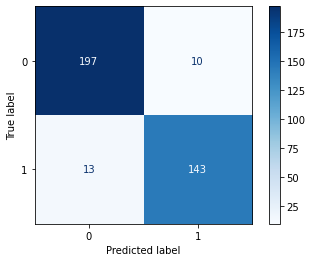

In [23]:
# Get predictions from model
pred_nb_cvec = gs_nb_cvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_nb_cvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_nb_cvec, cmap='Blues', values_format='d');

In [24]:
# Calculate the specificity
spec_nb_cvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_nb_cvec)

# Calculate the sensitivity
sens_nb_cvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_nb_cvec)

# Calculate the f1 score
f1_nb_cvec = round(f1_score(y_test, pred_nb_cvec), 4)
print('F1 Score: ', f1_nb_cvec)

Specificity:  0.9517
Sensitivity:  0.9167
F1 Score:  0.9256


ROC AUC Score:  0.9342


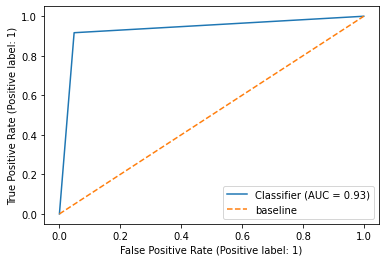

In [25]:
# Calculate ROC AUC Score and plotting ROC AUC Curve
get_roc_auc(pred_nb_cvec)

|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | F1 | ROC AUC |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**Count Vectorizer**| 0.9466 | 0.9366 | 197 | 10 | 13 | 143 | 0.9517 | 0.9167 | 0.9256 | 0.9342 |

From the above, we can see that the `Naive Bayes` Model with `Count Vectorizer` has improved a lot on the baseline. But as this is the first model, we cannot make any decisions on whether this model is the best or not. At this point, there is little to no overfitting of the model, so this is a good model for now.

The ROC AUC score is 0.9358, which means that for this model, the two classes for the subreddits are quite separated and distinguished.

#### 1.2 Naive Bayes Model with Tfidf Vectorizer

In [26]:
# Instantiate a Pipeline with TfidfVectorizer (Transformer) and MultinomialNB (Estimator)
pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwordslist)),
    ('nb', MultinomialNB())
])

# Hyperparameters for the above pipeline
pipe_nb_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000],
    'tvec__min_df': [1, 3, 5],
    'tvec__max_df': [.7, .8, .9],
    'tvec__ngram_range': [(1,1), (1,2)]    
}

In [27]:
# Instantiate GridSearchCV with pipeline of TfidfVectorizer (Transformer) and MultinomialNB (Estimator)
gs_nb_tvec = GridSearchCV(pipe_nb_tvec, pipe_nb_tvec_params, cv = 5, n_jobs = 4)

In [28]:
%%time
# Fit GridSearch to training data.
gs_nb_tvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_nb_tvec.best_params_

Wall time: 1min 18s


{'tvec__max_df': 0.7,
 'tvec__max_features': 4000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 1)}

In [29]:
# Score model on training set
print(round(gs_nb_tvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_nb_tvec.score(X_test, y_test), 4))

0.9512
0.9477


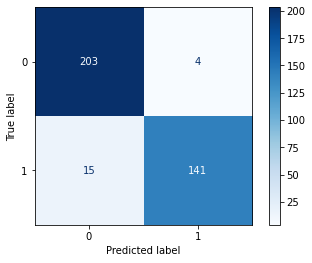

In [30]:
# Get predictions from model
pred_nb_tvec = gs_nb_tvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_nb_tvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_nb_tvec, cmap='Blues', values_format='d');

In [31]:
# Calculate the specificity
spec_nb_tvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_nb_tvec)

# Calculate the sensitivity
sens_nb_tvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_nb_tvec)

# Calculate the f1 score
f1_nb_tvec = round(f1_score(y_test, pred_nb_tvec), 4)
print('F1 Score: ', f1_nb_tvec)

Specificity:  0.9807
Sensitivity:  0.9038
F1 Score:  0.9369


ROC AUC Score:  0.9423


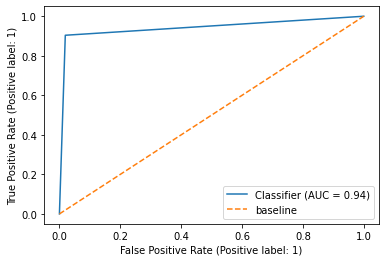

In [32]:
# Calculate ROC AUC Score and plotting ROC AUC Curve
get_roc_auc(pred_nb_tvec)

|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | F1 | ROC AUC |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**Count Vectorizer**| 0.9466 | 0.9366 | 197 | 10 | 13 | 143 | 0.9517 | 0.9167 | 0.9256 | 0.9342 |
|**Naive Bayes**|**Tfidf Vectorizer**| 0.9512 | 0.9477 | 203 | 4 | 15 | 141 | 0.9807 | 0.9038 | 0.9369 | 0.9423 |

From the start, the `Naive Bayes Model` with `Tfidf Vectorizer` transformer shows signs of overfitting as the test score is slightly worse. But, other than that, the accuracy of the model is slightly better than the other `Naive Bayes` Model. It should be noted that this model scores better in specificity, but worse off in sensitivity. Depending on our requirements of the models, we may consider this model.

This model has a higher ROC AUC score than the previous model, meaning that the two classes are even more separated, which is better for distinction of the target class.

### 2. Logistic Regression Model

#### 2.1 Logistic Regression Model with Count Vectorizer

In [33]:
# Instantiate a Pipeline with CountVectorizer (Transformer) and LogisticRegression (Estimator)
pipe_logreg_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwordslist)),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# Hyperparameters for the above pipeline
pipe_logreg_cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000],
    'cvec__min_df': [1, 3, 5],
    'cvec__max_df': [.7, .8, .9],
    'cvec__ngram_range': [(1,1), (1,2)]    
}

In [34]:
# Instantiate GridSearchCV with pipeline of CountVectorizer (Transformer) and LogisticRegression (Estimator)
gs_logreg_cvec = GridSearchCV(pipe_logreg_cvec, pipe_logreg_cvec_params, cv = 5, n_jobs = 4)

In [35]:
%%time
# Fit GridSearch to training data.
gs_logreg_cvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_logreg_cvec.best_params_

Wall time: 1min 21s


{'cvec__max_df': 0.7,
 'cvec__max_features': 2000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

In [36]:
# Score model on training set
print(round(gs_logreg_cvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_logreg_cvec.score(X_test, y_test), 4))

0.9991
0.9532


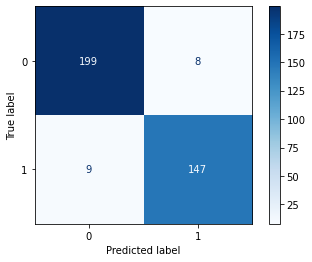

In [37]:
# Get predictions from model
pred_logreg_cvec = gs_logreg_cvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_logreg_cvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_logreg_cvec, cmap='Blues', values_format='d');

In [38]:
# Calculate the specificity
spec_logreg_cvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_logreg_cvec)

# Calculate the sensitivity
sens_logreg_cvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_logreg_cvec)

# Calculate the f1 score
f1_logreg_cvec = round(f1_score(y_test, pred_logreg_cvec), 4)
print('F1 Score: ', f1_logreg_cvec)

Specificity:  0.9614
Sensitivity:  0.9423
F1 Score:  0.9453


ROC AUC Score:  0.9518


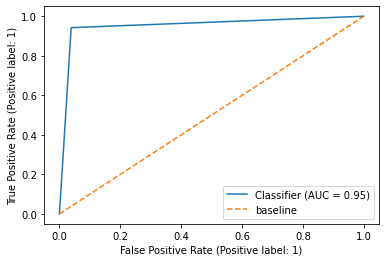

In [39]:
# Calculate ROC AUC Score and plotting ROC AUC Curve
get_roc_auc(pred_logreg_cvec)

|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | F1 | ROC AUC |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**Count Vectorizer**| 0.9466 | 0.9366 | 197 | 10 | 13 | 143 | 0.9517 | 0.9167 | 0.9256 | 0.9342 |
|**Naive Bayes**|**Tfidf Vectorizer**| 0.9512 | 0.9477 | 203 | 4 | 15 | 141 | 0.9807 | 0.9038 | 0.9369 | 0.9423 |
|**Logistics Regression**|**Count Vectorizer**| 0.9991 | 0.9532 | 199 | 8 | 9 | 147 | 0.9614 | 0.9423 | 0.9453 | 0.9518 |

As before, this model is quite overfit to the training data. But it should be noted here that scores for accuracy and sensitivity are the best among the three models thus far. However, this model can be further improved by making it less overfit.

With a ROC AUC score of 0.9518, this means that the two classes are even more separated than in the previous models, which is better for distinction of the target class.

#### 2.2 Logistic Regression Model with Tfidf Vectorizer

In [40]:
# Instantiate a Pipeline with TfidfVectorizer (Transformer) and LogisticRegression (Estimator)
pipe_logreg_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwordslist)),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# Hyperparameters for the above pipeline
pipe_logreg_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000],
    'tvec__min_df': [1, 3, 5],
    'tvec__max_df': [.7, .8, .9],
    'tvec__ngram_range': [(1,1), (1,2)]    
}

In [41]:
# Instantiate GridSearchCV with pipeline of TfidfVectorizer (Transformer) and LogisticRegression (Estimator)
gs_logreg_tvec = GridSearchCV(pipe_logreg_tvec, pipe_logreg_tvec_params, cv = 5, n_jobs = 4)

In [42]:
%%time
# Fit GridSearch to training data.
gs_logreg_tvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_logreg_tvec.best_params_

Wall time: 1min 26s


{'tvec__max_df': 0.7,
 'tvec__max_features': 2000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1)}

In [43]:
# Score model on training set
print(round(gs_logreg_tvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_logreg_tvec.score(X_test, y_test), 4))

0.9687
0.9559


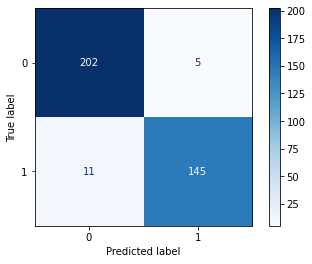

In [44]:
# Get predictions from model
pred_logreg_tvec = gs_logreg_tvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_logreg_tvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_logreg_tvec, cmap='Blues', values_format='d');

In [45]:
# Calculate the specificity
spec_logreg_tvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_logreg_tvec)

# Calculate the sensitivity
sens_logreg_tvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_logreg_tvec)

# Calculate the f1 score
f1_logreg_tvec = round(f1_score(y_test, pred_logreg_tvec), 4)
print('F1 Score: ', f1_logreg_tvec)

Specificity:  0.9758
Sensitivity:  0.9295
F1 Score:  0.9477


ROC AUC Score:  0.9527


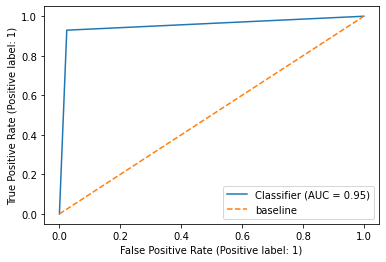

In [46]:
# Calculate ROC AUC Score and plotting ROC AUC Curve
get_roc_auc(pred_logreg_tvec)

|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | F1 | ROC AUC |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**Count Vectorizer**| 0.9466 | 0.9366 | 197 | 10 | 13 | 143 | 0.9517 | 0.9167 | 0.9256 | 0.9342 |
|**Naive Bayes**|**Tfidf Vectorizer**| 0.9512 | 0.9477 | 203 | 4 | 15 | 141 | 0.9807 | 0.9038 | 0.9369 | 0.9423 |
|**Logistics Regression**|**Count Vectorizer**| 0.9991 | 0.9532 | 199 | 8 | 9 | 147 | 0.9614 | 0.9423 | 0.9453 | 0.9518 |
|**Logistics Regression**|**Tfidf Vectorizer**| 0.9687 | 0.9559 | 202 | 5 | 11 | 145 | 0.971 | 0.9295 | 0.9477 | 0.9527 |

As before, this model is also overfit to the training data, but much less when compared to the same model with the `Count Vectorizer` transformer . Other than that, it shows similar scoring when compared to the `Naive Bayes` Model with `Tfidf Vectorizer` transformer, with a higher specificity but a lower sensitivity. As such, in a way, this model may be a better model with its higher sensitivity but lower specificity.

The ROC AUC score is slightly better than the same model with another transformer. 

### 3. K Nearest Neighbors Model

#### 3.1 K Nearest Neighbors Model with Count Vectorizer

In [47]:
# Instantiate a Pipeline with CountVectorizer (Transformer) and KNeighborsClassifier (Estimator)
pipe_knn_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwordslist)),
    ('knn', KNeighborsClassifier())
])

# Hyperparameters for the above pipeline
pipe_knn_cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000],
    'cvec__min_df': [1, 3, 5],
    'cvec__max_df': [.7, .8, .9],
    'cvec__ngram_range': [(1,1), (1,2)]    
}

In [48]:
# Instantiate GridSearchCV with pipeline of CountVectorizer (Transformer) and KNeighborsClassifier (Estimator)
gs_knn_cvec = GridSearchCV(pipe_knn_cvec, pipe_knn_cvec_params, cv = 5, n_jobs = 4)

In [49]:
%%time
# Fit GridSearch to training data.
gs_knn_cvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_knn_cvec.best_params_

Wall time: 1min 23s


{'cvec__max_df': 0.7,
 'cvec__max_features': 2000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

In [50]:
# Score model on training set
print(round(gs_knn_cvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_knn_cvec.score(X_test, y_test), 4))

0.7682
0.7824


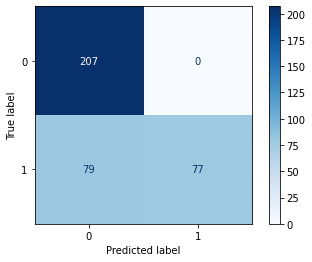

In [51]:
# Get predictions from model
pred_knn_cvec = gs_knn_cvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_knn_cvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_knn_cvec, cmap='Blues', values_format='d');

In [52]:
# Calculate the specificity
spec_knn_cvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_knn_cvec)

# Calculate the sensitivity
sens_knn_cvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_knn_cvec)

# Calculate the f1 score
f1_knn_cvec = round(f1_score(y_test, pred_knn_cvec), 4)
print('F1 Score: ', f1_knn_cvec)

Specificity:  1.0
Sensitivity:  0.4936
F1 Score:  0.6609


ROC AUC Score:  0.7468


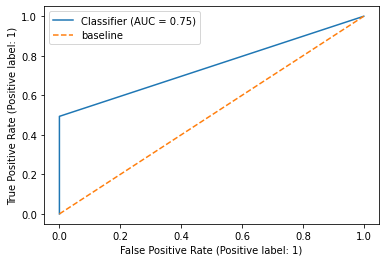

In [53]:
# Calculate ROC AUC Score and plotting ROC AUC Curve
get_roc_auc(pred_knn_cvec)

|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | F1 | ROC AUC |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**Count Vectorizer**| 0.9466 | 0.9366 | 197 | 10 | 13 | 143 | 0.9517 | 0.9167 | 0.9256 | 0.9342 |
|**Naive Bayes**|**Tfidf Vectorizer**| 0.9512 | 0.9477 | 203 | 4 | 15 | 141 | 0.9807 | 0.9038 | 0.9369 | 0.9423 |
|**Logistics Regression**|**Count Vectorizer**| 0.9991 | 0.9532 | 199 | 8 | 9 | 147 | 0.9614 | 0.9423 | 0.9453 | 0.9518 |
|**Logistics Regression**|**Tfidf Vectorizer**| 0.9687 | 0.9559 | 202 | 5 | 11 | 145 | 0.971 | 0.9295 | 0.9477 | 0.9527 |
|**K Neighbors Classifier**|**Count Vectorizer**| 0.7682 | 0.7824 | 207 | 0 | 79 | 77 | 1.0 | 0.4936 | 0.6609 | 0.7468 |

For this model, the first thing to note is that the accuracy has drastically dropped when compared to the previous models. While the specificity is 1, the sensitivity is very low as this model is making a lot more posts as not belonging to the targetted subreddit.

The ROC AUC score is 0.7468 means that the two classes are overlapping each other more compared to the previous models.

#### 3.2 KNeighborsClassifier Model with Tfidf Vectorizer

In [54]:
# Instantiate a Pipeline with TfidfVectorizer (Transformer) and KNeighborsClassifier (Estimator)
pipe_knn_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwordslist)),
    ('knn', KNeighborsClassifier())
])

# Hyperparameters for the above pipeline
pipe_knn_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000],
    'tvec__min_df': [1, 3, 5],
    'tvec__max_df': [.7, .8, .9],
    'tvec__ngram_range': [(1,1), (1,2)]    
}

In [55]:
# Instantiate GridSearchCV with pipeline of TfidfVectorizer (Transformer) and KNeighborsClassifier (Estimator)
gs_knn_tvec = GridSearchCV(pipe_knn_tvec, pipe_knn_tvec_params, cv = 5, n_jobs = 4)

In [56]:
%%time
# Fit GridSearch to training data.
gs_knn_tvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_knn_tvec.best_params_

Wall time: 1min 20s


{'tvec__max_df': 0.7,
 'tvec__max_features': 4000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

In [57]:
# Score model on training set
print(round(gs_knn_tvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_knn_tvec.score(X_test, y_test), 4))

0.9218
0.865


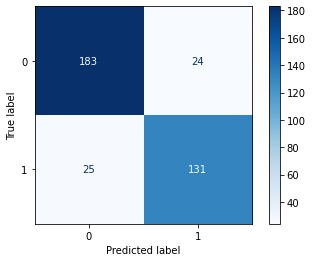

In [58]:
# Get predictions from model
pred_knn_tvec = gs_knn_tvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_knn_tvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_knn_tvec, cmap='Blues', values_format='d');

In [59]:
# Calculate the specificity
spec_knn_tvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_knn_tvec)

# Calculate the sensitivity
sens_knn_tvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_knn_tvec)

# Calculate the f1 score
f1_knn_tvec = round(f1_score(y_test, pred_knn_tvec), 4)
print('F1 Score: ', f1_knn_tvec)

Specificity:  0.8841
Sensitivity:  0.8397
F1 Score:  0.8424


ROC AUC Score:  0.8619


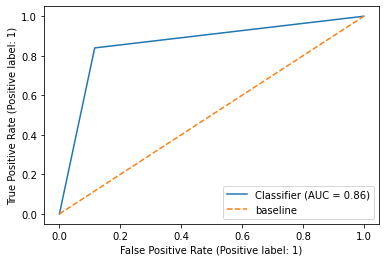

In [60]:
# Calculate ROC AUC Score and plotting ROC AUC Curve
get_roc_auc(pred_knn_tvec)

|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | F1 | ROC AUC |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**Count Vectorizer**| 0.9466 | 0.9366 | 197 | 10 | 13 | 143 | 0.9517 | 0.9167 | 0.9256 | 0.9342 |
|**Naive Bayes**|**Tfidf Vectorizer**| 0.9512 | 0.9477 | 203 | 4 | 15 | 141 | 0.9807 | 0.9038 | 0.9369 | 0.9423 |
|**Logistics Regression**|**Count Vectorizer**| 0.9991 | 0.9532 | 199 | 8 | 9 | 147 | 0.9614 | 0.9423 | 0.9453 | 0.9518 |
|**Logistics Regression**|**Tfidf Vectorizer**| 0.9687 | 0.9559 | 202 | 5 | 11 | 145 | 0.971 | 0.9295 | 0.9477 | 0.9527 |
|**K Neighbors Classifier**|**Count Vectorizer**| 0.7682 | 0.7824 | 207 | 0 | 79 | 77 | 1.0 | 0.4936 | 0.6609 | 0.7468 |
|**K Neighbors Classifier**|**Tfidf Vectorizer**| 0.9218 | 0.865 | 183 | 24 | 25 | 131 | 0.8841 | 0.8397 | 0.8424 | 0.8619 |

In the case of this model, the first thing to note is that the accuracy has improved when compared to the previous `K Neighbors Classifier` model, though it suffers from overfitting. However, when compared to the other models with the same `Tfidf Vectorizer` transformer, this fares worse. As such, we will not be considering this model for the final modelling.

### 4. Random Forest Classifier

#### 4.1 Random Forest Classifier Model with Count Vectorizer

In [61]:
# Instantiate a Pipeline with CountVectorizer (Transformer) and RandomForestClassifier (Estimator)
pipe_rf_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words = stopwordslist)),
    ('rf', RandomForestClassifier(random_state = 42))
])

# Hyperparameters for the above pipeline
pipe_rf_cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000],
    'cvec__min_df': [1, 3, 5],
    'cvec__max_df': [.7, .8, .9],
    'cvec__ngram_range': [(1,1), (1,2)]    
}

In [62]:
# Instantiate GridSearchCV with pipeline of CountVectorizer (Transformer) and RandomForestClassifier (Estimator)
gs_rf_cvec = GridSearchCV(pipe_rf_cvec, pipe_rf_cvec_params, cv = 5, n_jobs = 4)

In [63]:
%%time
# Fit GridSearch to training data.
gs_rf_cvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_rf_cvec.best_params_

Wall time: 1min 41s


{'cvec__max_df': 0.7,
 'cvec__max_features': 3000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2)}

In [64]:
# Score model on training set
print(round(gs_rf_cvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_rf_cvec.score(X_test, y_test), 4))

1.0
0.9366


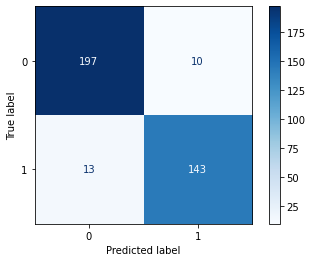

In [65]:
# Get predictions from model
pred_rf_cvec = gs_rf_cvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_rf_cvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_rf_cvec, cmap='Blues', values_format='d');

In [66]:
# Calculate the specificity
spec_rf_cvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_rf_cvec)

# Calculate the sensitivity
sens_rf_cvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_rf_cvec)

# Calculate the f1 score
f1_rf_cvec = round(f1_score(y_test, pred_rf_cvec), 4)
print('F1 Score: ', f1_rf_cvec)

Specificity:  0.9517
Sensitivity:  0.9167
F1 Score:  0.9256


ROC AUC Score:  0.9342


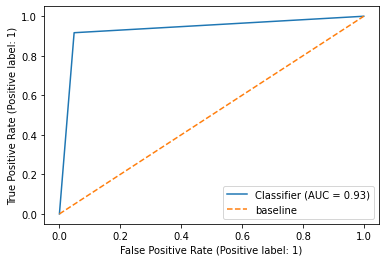

In [67]:
# Calculate ROC AUC Score and plotting ROC AUC Curve
get_roc_auc(pred_rf_cvec)

|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | F1 | ROC AUC |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**Count Vectorizer**| 0.9466 | 0.9366 | 197 | 10 | 13 | 143 | 0.9517 | 0.9167 | 0.9256 | 0.9342 |
|**Naive Bayes**|**Tfidf Vectorizer**| 0.9512 | 0.9477 | 203 | 4 | 15 | 141 | 0.9807 | 0.9038 | 0.9369 | 0.9423 |
|**Logistics Regression**|**Count Vectorizer**| 0.9991 | 0.9532 | 199 | 8 | 9 | 147 | 0.9614 | 0.9423 | 0.9453 | 0.9518 |
|**Logistics Regression**|**Tfidf Vectorizer**| 0.9687 | 0.9559 | 202 | 5 | 11 | 145 | 0.971 | 0.9295 | 0.9477 | 0.9527 |
|**K Neighbors Classifier**|**Count Vectorizer**| 0.7682 | 0.7824 | 207 | 0 | 79 | 77 | 1.0 | 0.4936 | 0.6609 | 0.7468 |
|**K Neighbors Classifier**|**Tfidf Vectorizer**| 0.9218 | 0.865 | 183 | 24 | 25 | 131 | 0.8841 | 0.8397 | 0.8424 | 0.8619 |
|**Random Forest Classifier**|**Count Vectorizer**| 1.0 | 0.9366 | 197 | 10 | 13 | 143 | 0.9517 | 0.9167 | 0.9256 | 0.9342 |

In the case of this model, it suffers from overfitting as well. In many various aspects, this `Random Forest Classifier` Model is similar to the `Naive Bayes` model with `Count Vectorizer` transformer. As such, we will keep this model in mind for now.

#### 4.2 Random Forest Classifier Model with Tfidf Vectorizer

In [68]:
# Instantiate a Pipeline with TfidfVectorizer (Transformer) and RandomForestClassifier (Estimator)
pipe_rf_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stopwordslist)),
    ('rf', RandomForestClassifier(random_state = 42))
])

# Hyperparameters for the above pipeline
pipe_rf_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000],
    'tvec__min_df': [1, 3, 5],
    'tvec__max_df': [.7, .8, .9],
    'tvec__ngram_range': [(1,1), (1,2)]    
}

In [69]:
# Instantiate GridSearchCV with pipeline of TfidfVectorizer (Transformer) and RandomForestClassifier (Estimator)
gs_rf_tvec = GridSearchCV(pipe_rf_tvec, pipe_rf_tvec_params, cv = 5, n_jobs = 4)

In [70]:
%%time
# Fit GridSearch to training data.
gs_rf_tvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_rf_tvec.best_params_

Wall time: 1min 48s


{'tvec__max_df': 0.7,
 'tvec__max_features': 4000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [71]:
# Score model on training set
print(round(gs_rf_tvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_rf_tvec.score(X_test, y_test), 4))

1.0
0.9449


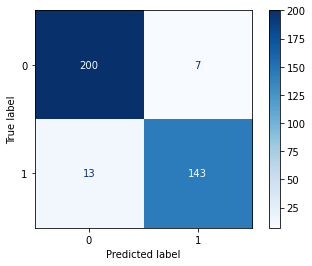

In [72]:
# Get predictions from model
pred_rf_tvec = gs_rf_tvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_rf_tvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_rf_tvec, cmap='Blues', values_format='d');

In [73]:
# Calculate the specificity
spec_rf_tvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_rf_tvec)

# Calculate the sensitivity
sens_rf_tvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_rf_tvec)

# Calculate the f1 score
f1_rf_tvec = round(f1_score(y_test, pred_rf_tvec), 4)
print('F1 Score: ', f1_rf_tvec)

Specificity:  0.9662
Sensitivity:  0.9167
F1 Score:  0.9346


ROC AUC Score:  0.9414


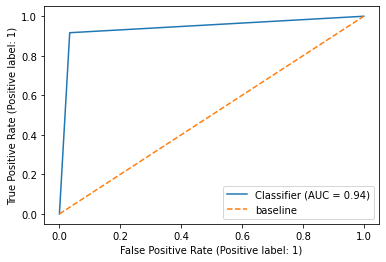

In [74]:
# Calculate ROC AUC Score and plotting ROC AUC Curve
get_roc_auc(pred_rf_tvec)

|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | F1 | ROC AUC |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**Count Vectorizer**| 0.9466 | 0.9366 | 197 | 10 | 13 | 143 | 0.9517 | 0.9167 | 0.9256 | 0.9342 |
|**Naive Bayes**|**Tfidf Vectorizer**| 0.9512 | 0.9477 | 203 | 4 | 15 | 141 | 0.9807 | 0.9038 | 0.9369 | 0.9423 |
|**Logistics Regression**|**Count Vectorizer**| 0.9991 | 0.9532 | 199 | 8 | 9 | 147 | 0.9614 | 0.9423 | 0.9453 | 0.9518 |
|**Logistics Regression**|**Tfidf Vectorizer**| 0.9687 | 0.9559 | 202 | 5 | 11 | 145 | 0.971 | 0.9295 | 0.9477 | 0.9527 |
|**K Neighbors Classifier**|**Count Vectorizer**| 0.7682 | 0.7824 | 207 | 0 | 79 | 77 | 1.0 | 0.4936 | 0.6609 | 0.7468 |
|**K Neighbors Classifier**|**Tfidf Vectorizer**| 0.9218 | 0.865 | 183 | 24 | 25 | 131 | 0.8841 | 0.8397 | 0.8424 | 0.8619 |
|**Random Forest Classifier**|**Count Vectorizer**| 1.0 | 0.9366 | 197 | 10 | 13 | 143 | 0.9517 | 0.9167 | 0.9256 | 0.9342 |
|**Random Forest Classifier**|**Tfidf Vectorizer**| 1.0 | 0.9449 | 200 | 7 | 13 | 143 | 0.9662 | 0.9167 | 0.9346 | 0.9414 |

Like the other `Random Forest Classifier` Model, this model also suffers from overfitting as well. However, it differs from the other `Random Forest Classifier` Model by having a higher sensitivity but lower specificity.

### 5. Final Model

For the choice of the final model, we will be selecting the model based on the accuracy (`Test Score`) and then the `specificity` of the models.

As such, the final model chosen is the `Logistics Regression` model with the `Tfidf Vectorizer` transformer, as it has the `highest accuracy at 0.9559`, and the `3rd highest specificity at 0.971`.

In [75]:
# Instantiate (Transformer) and (Estimator) with best parameters from the chosen model
tvec = TfidfVectorizer(stop_words = stopwordslist, max_df = 0.7, max_features = 2000, min_df = 1, ngram_range = (1,1))
logreg = LogisticRegression(solver='liblinear')

In [76]:
# fit and transform training data
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                            columns = tvec.get_feature_names_out(), index = X_train.index)

# transform testing data
X_test_tvec = pd.DataFrame(tvec.transform(X_test).todense(), 
                           columns = tvec.get_feature_names_out(), index = X_test.index)

# fit model
model_logreg = logreg.fit(X_train_tvec, y_train)

Training Score:  0.9687
Testing Score:  0.9559
Specificity:  0.9758
Sensitivity:  0.9295
F1 Score:  0.9477


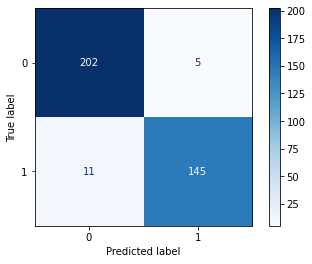

In [77]:
## Reposting the scores again
# Score model on training set
print('Training Score: ', round(model_logreg.score(X_train_tvec, y_train), 4))

# Score model on testing set
print('Testing Score: ', round(model_logreg.score(X_test_tvec, y_test), 4))

# Get predictions from model
preds = model_logreg.predict(X_test_tvec)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate the specificity
print('Specificity: ', round(tn / (tn + fp), 4))

# Calculate the sensitivity
print('Sensitivity: ', round(tp / (tp + fn), 4))

# Calculate the f1 score
print('F1 Score: ', round(f1_score(y_test, preds), 4))

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap='Blues', values_format='d');

In [78]:
# Feature Coefficients
word_coef = pd.DataFrame({'Word': model_logreg.feature_names_in_, 'Coef': model_logreg.coef_[0]})

In [79]:
# top 20 words related to the target subreddit nosleep
word_coef_nosleep = word_coef.sort_values('Coef', ascending=False).head(20)
display(word_coef_nosleep)

,Word,Coef
823,hand,1.996211
634,eye,1.566532
193,blood,1.466262
1915,want,1.424392
1475,said,1.400875
1494,scream,1.360905
1909,wait,1.298852
836,head,1.266081
1835,tri,1.207147
1024,let,1.165315


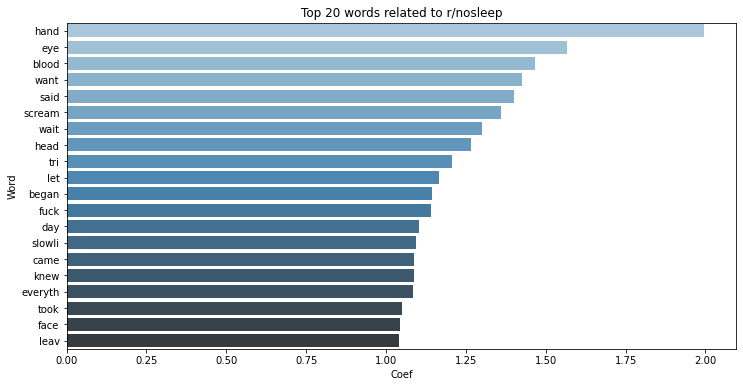

In [111]:
# plot of top 20 words related to the target subreddit nosleep
plt.figure(figsize=(12, 6));
plt.title('Top 20 words related to r/nosleep')
sns.barplot(x = 'Coef', y = 'Word', data = word_coef_nosleep, palette = "Blues_d");

In [81]:
# top 20 words related to the other subreddit paranormal
word_coef_paranormal = word_coef.sort_values('Coef', ascending=False).tail(20)
display(word_coef_paranormal)

,Word,Coef
25,activ,-0.609375
1045,live,-0.616699
152,bedroom,-0.618721
528,dream,-0.623200
1690,stori,-0.635269
1588,skeptic,-0.684858
151,bed,-0.705811
911,idk,-0.717469
1315,post,-0.735150
280,cat,-0.738684


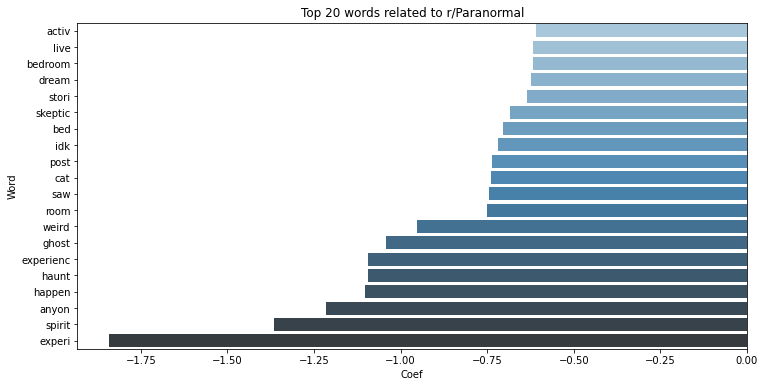

In [104]:
# plot of top 20 words related to the target subreddit nosleep
plt.figure(figsize=(12, 6));
plt.title('Top 20 words related to r/Paranormal')
sns.barplot(x = 'Coef', y = 'Word', data = word_coef_paranormal, palette = "Blues_d");

In [83]:
# top 20 words related to both subreddits
top_feats_df = pd.concat([
    pd.DataFrame(word_coef_nosleep['Word']).reset_index(drop = True),
    pd.DataFrame(word_coef_paranormal['Word']).reset_index(drop = True)],
    axis = 1
)
top_feats_df.set_axis(['r/nosleep', 'r/Paranormal'], axis = 1)

,r/nosleep,r/Paranormal
0,hand,activ
1,eye,live
2,blood,bedroom
3,want,dream
4,said,stori
5,scream,skeptic
6,wait,bed
7,head,idk
8,tri,post
9,let,cat


From the above, you can see the top 20 words that is most likely to be related to the two subreddits based on the `Logistics Regression` model. 

It is interesting to note that for the subreddit `paranormal`, words such as `ghost`, `spirit`, `weird` and `haunt` which are clearly related to the paranormal show up. The stemmed words `experi` and `experienc` which is related to the words `experiment` and `experience` also showed up as well. It is also interesting to note that `bed`, `bedroom`, `room` and `dream` also showed up together, indicating the place of where the paranormal experience happens.

On the other side, for the subreddit `nosleep`, the top 20 words are more or less generic with none that is clearly distinct. Since the posts of the subreddit are in the style of a story told in first-person, this is quite expected. The use of vulgarities may thus be related to this.

#### 5.1 Misclassifications

Next, let's take a look to see at the misclassifications to see how to further improve the model.

In [84]:
# redefining the dataframe for testing set
df_test = df.loc[X_test.index][['subreddit', 'text_stem']]
df_test.head()

,subreddit,text_stem
1308,0,friendli ghost knock front door let know famil...
503,1,nouvel vie ancien mort ami lecteur bonjour c e...
1443,0,saw shadow figur door alway sleep door close e...
66,1,ate ga station sushi weirdo drunk night someho...
1319,0,heal abil phsycic ladi told im healer especi a...


In [85]:
# Adding the predicted column to the testing set
df_test['predictions'] = preds
df_test.head()

,subreddit,text_stem,predictions
1308,0,friendli ghost knock front door let know famil...,0
503,1,nouvel vie ancien mort ami lecteur bonjour c e...,0
1443,0,saw shadow figur door alway sleep door close e...,0
66,1,ate ga station sushi weirdo drunk night someho...,1
1319,0,heal abil phsycic ladi told im healer especi a...,0


In [86]:
# creating lists of the top 50 and bottom 50 word features based on coefficients of model
nosleep_words = list(word_coef.sort_values('Coef', ascending=False)['Word'].head(50))
paranormal_words = list(word_coef.sort_values('Coef', ascending=False)['Word'].tail(50))

#### 5.1.1 False Positives (Type I Errors)

In [87]:
# Generating dataframe of False Positives
fp_text = df_test[df_test['subreddit'] == 0]
fp_text = fp_text[fp_text['predictions'] == 1]
fp_text

,subreddit,text_stem,predictions
1133,0,first experi came face face black dog lie expe...,1
816,0,pareidolia work cold miss hiker case id end se...,1
1165,0,saw recent friend recal unexplain possibl expe...,1
1425,0,opinion sourc premonit instanc go describ sign...,1
626,0,weird dream sort cross post r highstrang reque...,1


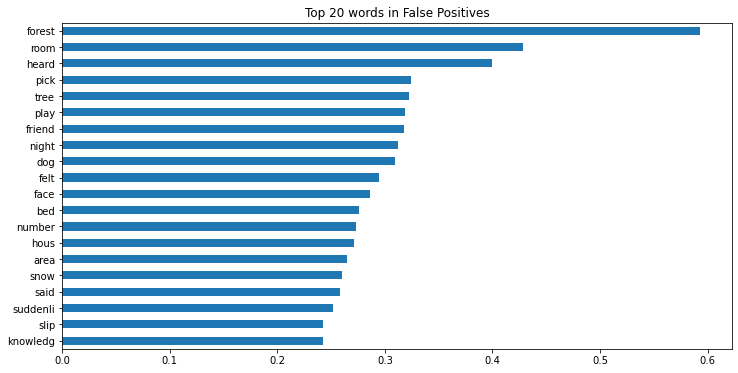

In [88]:
# Instantiate a TfidfVectorizer with stop words
tvec_fp = TfidfVectorizer(stop_words = stopwordslist)

# Fit the vectorizer
tvec_fp.fit(fp_text['text_stem'])

# Transform 
fp_words = tvec_fp.transform(fp_text['text_stem'])

# Convert into a DataFrame.
fp_words_df = pd.DataFrame(fp_words.todense(), 
                            columns = tvec_fp.get_feature_names_out())

# plot top occurring words in false positives
plt.figure(figsize=(12, 6));
plt.title('Top 20 words in False Positives')
fp_words_df.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh');

In [89]:
# generating a list of the top 20 words in false positives
fp_words_list = list(fp_words_df.sum().sort_values(ascending = True).tail(20).index)

# Identifying the common words between the false positives and the top 50 word features for the model 
fp_words_nosleep = [word for word in fp_words_list if word in nosleep_words]
print(fp_words_nosleep)

['said', 'face']


For these posts that are misclassified as being from the `nosleep` subreddit, it can be seen from above that the top word features in these posts are of generic common words that is similar to the posts from the `nosleep` subreddit. Added to that are the words `said` and `face` being used that are among the top word features of the `nosleep` subreddit. Hence, these are most likely the reasons why these posts are misclassified.

#### 5.1.2 False Negatives (Type II Errors)

In [90]:
## False Negatives
fn_text = df_test[df_test['subreddit'] == 1]
fn_text = fn_text[fn_text['predictions'] == 0]
fn_text

,subreddit,text_stem,predictions
503,1,nouvel vie ancien mort ami lecteur bonjour c e...,0
281,1,encount sleep paralysi demon midget eye eerili...,0
589,1,bet sinc kid close cousin steve one thing love...,0
398,1,follow light happen twenti year ago still reme...,0
117,1,true crazi stori grandma told mother start tel...,0
577,1,olga move us maintain twitter account follow r...,0
50,1,רצון האבוד lost testament discov littl noth kn...,0
177,1,clock man game stori clock man game clock man ...,0
442,1,mad stalker happen 2002 live ground floor apar...,0
9,1,thing bed last night cat hey realli know start...,0


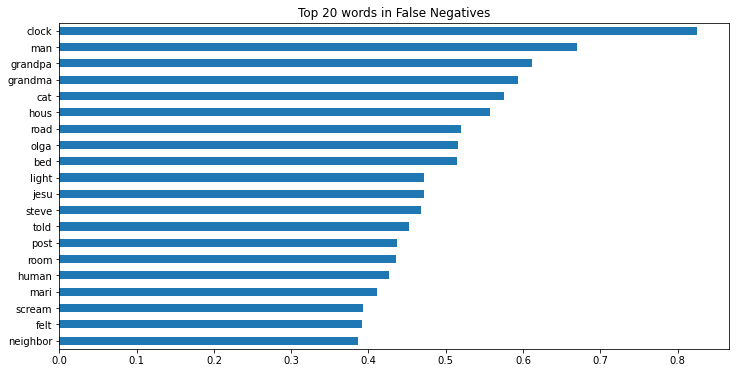

In [91]:
# Instantiate a TfidfVectorizer with stop words
tvec_fn = TfidfVectorizer(stop_words = stopwordslist)

# Fit the vectorizer
tvec_fn.fit(fn_text['text_stem'])

# Transform 
fn_words = tvec_fn.transform(fn_text['text_stem'])

# Convert into a DataFrame.
fn_words_df = pd.DataFrame(fn_words.todense(), 
                            columns = tvec_fn.get_feature_names_out())

# plot top occurring words in false positives
plt.figure(figsize=(12, 6));
plt.title('Top 20 words in False Negatives')
fn_words_df.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh');

In [92]:
# generating a list of the top 20 words in false negatives
fn_words_list = list(fn_words_df.sum().sort_values(ascending = True).tail(20).index)

# Identifying the common words between the false positives and the bottom 50 word features for the model 
fn_words_paranormal = [word for word in fn_words_list if word in paranormal_words]
print(fn_words_paranormal)

['room', 'post', 'bed', 'cat', 'grandpa']


For these posts that are misclassified as being from the `paranormal` subreddit, it can be seen from above that the top word features in these posts are of generic common words. However, there are the words `room`, `post`, `bed`, `cat`, `grandpa` being used that are among the top word features of the `paranormal` subreddit. 

Also, some of the misclassed posts contain quite a number of non-English words which is likely to skew the predictions of the model.

Hence, these are most likely the reasons why these posts are misclassified.

### 6. Conclusion

The final model chosen for this project is the `Logistics Regression` model with the `Tfidf Vectorizer` transformer, with an accuracy score of `95.59%` and a specificity score of `97.58%`. 

Even though these scores are impressive, it should be noted that all of the models are based on their default parameters. These meant that there can be further improvements to the model if the parameters of the model are also adjusted to be optimal. In this case, this may be important as the default model may not be the best even though adjustments have been made in the Grid Search process to alter the parameters of the transformer. Of course, the time taken to complete each Grid Search will be exponentially increased, and thus this might not be the best way to conduct this process of optimization.

In the future, it might be good to reduce the amount of parameters chosen for the transformer and add the parameters for the model into the modelling process to refine the models in order to decide on the best model possible for the purpose of classification.

--------

Due to the time constraint, it should be noted that text analysis is based on the text after stemming is done on it, and the model is thus based on those text. As `Porter Stemmer` is an aggressive form of text processing, the words generated may be inaccurate to their original meaning or even indecipherable at first glance. 

For future work, further analysis can be done on the other forms of pre-processing of the text, which includes no stemming or lemmatization, and other forms of text lemmatization or stemming like `spaCy lemmatizater` and `Snowball Stemmer`.

---------

While it can be seen that the final model is doing quite well for the two subreddits chosen, there is an inherent issue here. The two subreddits chosen are of the text-heavy variety and they are not entirely similar in terms of the topic of interest. This means that the adaptation of this model to other subreddits may not work out that well. It should also be noted that there are usually more than two subreddits that are quite similar to each other, and since this model is currently catered towards working with two subreddits, that means more work to be done in the selection of the model.

For future progress, the aim is to work towards adapting this model to a subreddit that is less text-heavy as well as adapting to subreddits that are very similar to each other would be more useful to the user. After that, it might be prudent to work towards multi-classification which is currently beyond the scope of this project.